# Mini-Project

In [2]:
import torch
import torch.nn as nn
import numpy as np
import torch.utils.data as data
import copy
import matplotlib.pyplot as plt
import time
import gc

from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

## Loading Data and Preprocessing
The first task of our project is to load the CIFAR-10 image classification dataset and split it into training set and test set.

As the dataset is made up of colored images with three color channels, we need to normalize over the three color channels.

In [21]:
# download the dataset
train_data = datasets.CIFAR10(root='./data', train=True, download=True)
test_data = datasets.CIFAR10(root='./data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
# Compute means and standard deviations along the R,G,B channel
means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255
print(f"Means: {means}")
print(f"Stds: {stds}")

Means: [0.49139968 0.48215841 0.44653091]
Stds: [0.24703223 0.24348513 0.26158784]


The next step is to do some data augmentation. We will crop the images and padding on them, flip them with probability 0.5 and finally normalize each color channel.

In [23]:
# Define transform
transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=2),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((-3,3)),
        transforms.ColorJitter(brightness=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=means, std=stds)
])



transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Then, we’ll load the dataset along with the transforms we just defined.

In [24]:
# test_dataloader
train_data = datasets.CIFAR10(root='./data', train=True, transform=transform_train)
test_data = datasets.CIFAR10(root='./data', train=False, transform=transform_test)

BATCH_SIZE = 64
train_loader = data.DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)
test_loader = data.DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False, num_workers = 2)

print(len(train_data))
print(len(test_data))

50000
10000


In order to monitor loss along different epochs, we also created a validation set with 10% of the training samples.

Now, we define a method to print some images so as to see how they lool like. As "plt.imshow" expect input data with RGB data ([0..1] for floats or [0..255] for integers, so we also define a method to normalize images. This part of the code is partly borrowed from HW2.

In [25]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [26]:
def plot_images(images, labels, classes, normalize=False):
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_xticks([])
        ax.set_yticks([])
        image = images[i]

        if normalize:
            normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])

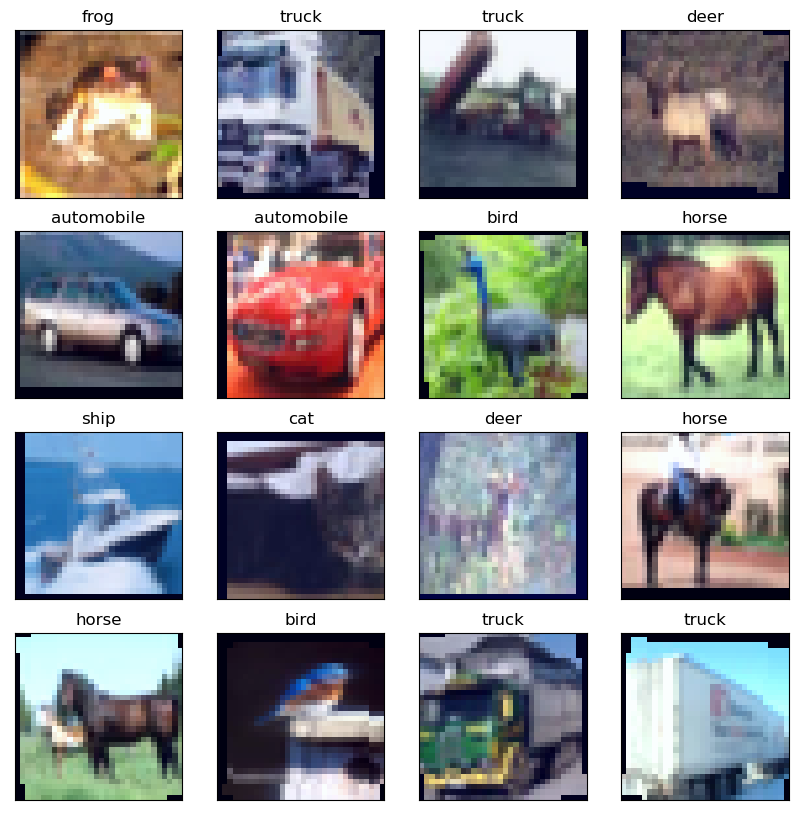

In [27]:
N_IMAGES = 16
images, labels = zip(*[(image, label) for image, label in [train_data[i] for i in range(N_IMAGES)]])
classes = test_data.classes

plot_images(images, labels, classes, normalize=True)

## Defining the Model
We implement our model with reference to [pytorch ResNet](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py).

Firstly, define the device that we use.

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Next, we built the basic block for the residual layers. It consist of two convolutional layers with skip connections. After each convolution layer, we applied batch normalization and ReLU activation to the output. Meanwhile, the block contains a skip connection that is an optional parameter (downsample). 
The parameter we set for the block is as follows:

* Fi: 3, the Conv. kernal size is 3.


In [11]:
class Block(nn.Module):

    def __init__(self, input_channels, output_channels, stride = 1, downsample = None):
        super(Block, self).__init__()

        # conv1
        self.conv1 = nn.Sequential(
                        nn.Conv2d(input_channels, output_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(output_channels),
                        nn.ReLU())
        
        # conv2
        self.conv2 = nn.Sequential(
                        nn.Conv2d(output_channels, output_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(output_channels))
        
        # skip connection
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.output_channels = output_channels

    def forward(self, x):
        identity = x
        out = self.conv2(self.conv1(x))

        if self.downsample:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        return out

Now, we are going to define the ResNet-18 model. To make layer with blocks, we create a helper function _make_layer. After that, we add the average pooling and the final fully-connected layer. The parameters we set for the model are as follows:

N: $4$: this is the number of our residual layer, each of these layers will contain a specific number of our customized residual block.  
B: $[2,4,4,1]$: this is the number of residual blocks in each residual layer.  
C: $[64,96,128,512]$: this is the number of channels in each residual layer.  
Stride: $[1,2,2,2]$: this is the stride of the first convolution layer in our customized residual block.  
P: $4$: this is the size of the average pooling kernel.  




In [12]:
class ResNet_23(nn.Module):
    def __init__(self, block, num_classes = 10):
        super(ResNet_23, self).__init__()
        self.input_channels = 64

        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())

        self.layer0 = self._make_layer(block, 64, 2, stride = 1)
        self.layer1 = self._make_layer(block, 96, 4, stride = 2)
        self.layer2 = self._make_layer(block, 128, 4, stride = 2)
        self.layer3 = self._make_layer(block, 512, 1, stride = 2)

        self.avgpool = nn.AvgPool2d(4, stride=1)
        self.fc = nn.Linear(512, num_classes)
        self.droupout = nn.Dropout(p=0.05)

    def _make_layer(self, block, output_channels, block_num, stride=1):
        downsample = None

        if stride != 1:
            downsample = nn.Sequential(
                            nn.Conv2d(self.input_channels, output_channels, kernel_size=1, stride=stride),
                            nn.BatchNorm2d(output_channels))
        
        layers = []
        layers.append(block(self.input_channels, output_channels, stride, downsample))
        self.input_channels = output_channels

        for i in range(1, block_num):
            layers.append(block(self.input_channels, output_channels))

        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.droupout(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

Then, we will set some hyper-parameters for our model. The hyper-parameters include defining the learning rate, loss function along with the optimizer.

In [13]:
from torchsummary import summary

model = ResNet_23(Block, 10).to(device)

summary(model, (3, 32, 32),device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,472
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,928
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
            Block-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,928
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

Lastly, count the total number of trainable parameters. In our model, there are 4,985,386 parameters, which is slightly less than 5 million.

## Training & Test

Firstly, we define a function to tell us how long an epoch takes. This method is quoted from code of hw2.

In [14]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [15]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum = 0.9, weight_decay=1e-5)

In [16]:
TRAIN_ACC = []
TEST_ACC = []
TRAIN_LOSS = []
TEST_LOSS = []

Now, we will train our model for 20 epochs and compute the validation accuracy at the end of each epoch. This part of the code is partly borrowed from HW2.

In [45]:
NUM_EMPOCHS = 40
BEST_ACC = 0

for epoch in range(NUM_EMPOCHS):
    start_time = time.time()
    batch_loss = 0
    n_correct = 0
    n_samples = 0
    # train
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        # cal loss and acc
        batch_loss += loss.item()
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs

    elapsed_mins, elapsed_secs = epoch_time(start_time, time.time())
    acc_train = 100.0 * n_correct / n_samples
    loss_train = batch_loss/len(train_loader)
    TRAIN_ACC.append(acc_train)
    TRAIN_LOSS.append(loss_train)
    print(f"Epoch {epoch + 1:02}/{NUM_EMPOCHS} | {elapsed_mins}m{elapsed_secs}s:")
    print(f"    Train Loss: {loss_train:.4f}, train Acc: {acc_train:.4f}%")

    # test
    with torch.no_grad():
        correct = 0
        total = 0
        batch_loss = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # cal loss and acc
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            batch_loss += loss.item()
            del images, labels, outputs
            
        acc_test = 100 * correct / total
        loss_test = batch_loss/len(test_loader)
        TEST_ACC.append(acc_test)
        TEST_LOSS.append(loss_test)
        print(f"    Test  Loss: {loss_test:.4f}, test  Acc: {acc_test:.4f}%")
    
        # save model
        file = "model_" + str(epoch+1) + ".pth"
        if(acc_test > BEST_ACC):
            BEST_ACC = acc_test
            torch.save(model.state_dict(), file)
    
    torch.cuda.empty_cache()
    gc.collect()

Epoch 01/40 | 0m45s:
    Train Loss: 1.6625, train Acc: 39.3540%
    Test  Loss: 1.3287, test  Acc: 51.9500%
Epoch 02/40 | 0m44s:
    Train Loss: 1.1740, train Acc: 58.4660%
    Test  Loss: 0.9298, test  Acc: 67.5700%
Epoch 03/40 | 0m45s:
    Train Loss: 0.8916, train Acc: 68.9120%
    Test  Loss: 0.7620, test  Acc: 74.6300%
Epoch 04/40 | 0m44s:
    Train Loss: 0.7327, train Acc: 74.7940%
    Test  Loss: 0.6574, test  Acc: 77.8700%
Epoch 05/40 | 0m45s:
    Train Loss: 0.6304, train Acc: 78.6120%
    Test  Loss: 0.6096, test  Acc: 80.2500%
Epoch 06/40 | 0m44s:
    Train Loss: 0.5688, train Acc: 80.7900%
    Test  Loss: 0.5396, test  Acc: 82.3300%
Epoch 07/40 | 0m44s:
    Train Loss: 0.5128, train Acc: 82.7800%
    Test  Loss: 0.5051, test  Acc: 83.3100%
Epoch 08/40 | 0m44s:
    Train Loss: 0.4661, train Acc: 84.3020%
    Test  Loss: 0.4737, test  Acc: 84.6100%
Epoch 09/40 | 0m45s:
    Train Loss: 0.4329, train Acc: 85.4700%
    Test  Loss: 0.4551, test  Acc: 85.2000%
Epoch 10/40 | 0m45s

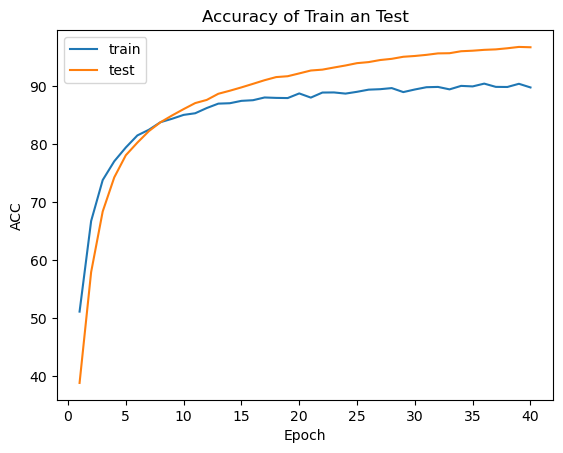

In [46]:
EPOCHS = [i for i in range(1,41)]
plt.plot(EPOCHS, TEST_ACC)
plt.plot(EPOCHS, TRAIN_ACC)
plt.xlabel('Epoch')
plt.ylabel('ACC')
plt.legend(['train', 'test'], loc='upper left')
plt.title("Accuracy of Train an Test")
plt.show()

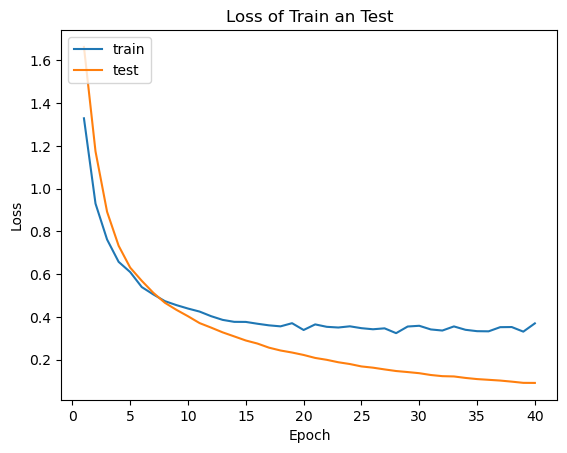

In [47]:
plt.plot(EPOCHS, TEST_LOSS)
plt.plot(EPOCHS, TRAIN_LOSS)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.title("Loss of Train an Test")
plt.show()

## load data

In [37]:
net = ResNet_23(Block, 10).to(device)
net.load_state_dict(torch.load("model_36.pth"))

<All keys matched successfully>

In [38]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

Accuracy Rate = 91.26%


<Figure size 2500x400 with 0 Axes>

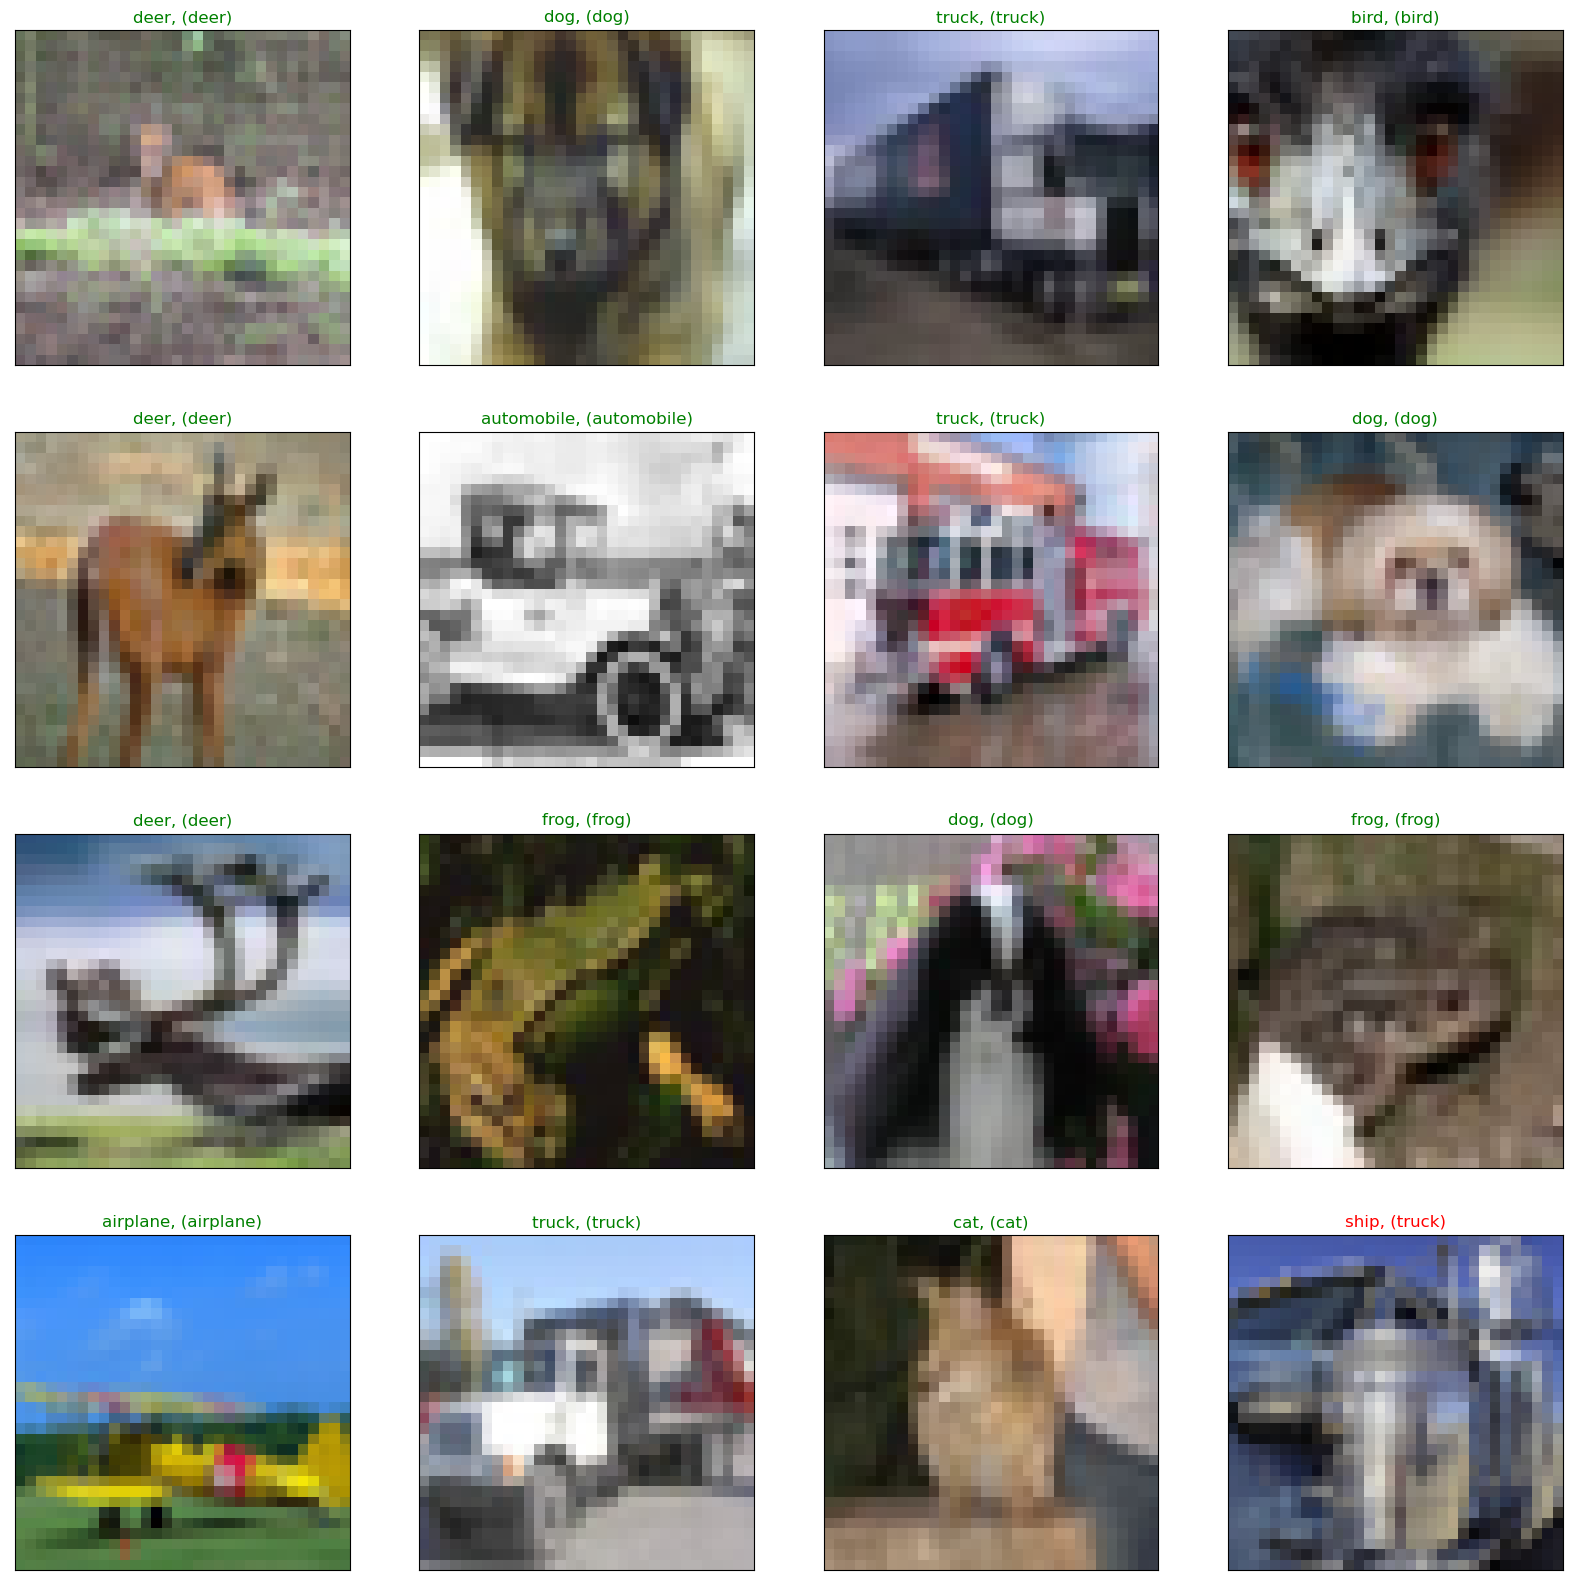

In [45]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(20,20))
for idx in np.arange(16):    
    ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
    imshow(images[idx+32])
    ax.set_title("{}, ({})".format(classes[val_preds[idx+32].item()], classes[labels[idx+32].item()]), 
                 color = ("green" if val_preds[idx+32].item()==labels[idx+32].item() else "red"))

In [47]:
train_loss_dict = []
train_acc_dict = []
model = net

with torch.no_grad():

    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(images.shape[0]):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    train_acc_dict.append(acc)

    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 91.26 %
Accuracy of airplane: 93.462 %
Accuracy of automobile: 95.66199999999999 %
Accuracy of bird: 85.762 %
Accuracy of cat: 82.16199999999999 %
Accuracy of deer: 92.862 %
Accuracy of dog: 85.562 %
Accuracy of frog: 93.862 %
Accuracy of horse: 90.262 %
Accuracy of ship: 93.562 %
Accuracy of truck: 94.362 %
